<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Load-library" data-toc-modified-id="Load-library-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load library</a></span></li><li><span><a href="#ConvNets" data-toc-modified-id="ConvNets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ConvNets</a></span></li><li><span><a href="#One-Channels" data-toc-modified-id="One-Channels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>One Channels</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Preparing-dataset" data-toc-modified-id="Preparing-dataset-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preparing dataset</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Transfer-learning" data-toc-modified-id="Transfer-learning-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Transfer learning</a></span></li></ul></li><li><span><a href="#One-Channels-(random)" data-toc-modified-id="One-Channels-(random)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>One Channels (random)</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Split-the-data" data-toc-modified-id="Split-the-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Split the data</a></span></li><li><span><a href="#Random-the-peak" data-toc-modified-id="Random-the-peak-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Random the peak</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#Two-Channels" data-toc-modified-id="Two-Channels-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Two Channels</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Check-the-efficiency-of-the-generator-of-colored-noises" data-toc-modified-id="Check-the-efficiency-of-the-generator-of-colored-noises-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Check the efficiency of the generator of colored noises</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Predict</a></span></li><li><span><a href="#Plot-AUC" data-toc-modified-id="Plot-AUC-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Plot AUC</a></span></li></ul></li></ul></div>

# Load library

In [1]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

import numpy as np
import pandas as pd
from itertools import product, permutations

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-re00loading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

CPU or GPU? :  cpu(0)


# ConvNets

# One Channels

## Load Data

In [2]:
%%time
if ctx == mx.cpu():
    GW_address = './data/GW_data/'
    noise_GWtrain = pd.read_csv(GW_address+'LigoNose9_9000_8192_2.csv', index_col=0, nrows=1000)
    noise_puretrain = noise_GWtrain
    noise_GWtest = noise_GWtrain
    noise_puretest = noise_GWtrain
    print('The shape of colored noise:', noise_GWtrain.shape)
elif ctx == mx.gpu():
    GW_address = '../input/'

GW_train = pd.read_csv(GW_address + 'GW_train_full.csv',index_col=0)
GW_test = pd.read_csv(GW_address + 'GW_test_full.csv',index_col=0)
print('The shape of training GW sinals:', GW_train.shape)
print('The shape of testing GW sinals:', GW_test.shape)

plt.plot(GW_train.sample(1).values[0])
plt.show()

GW_train.head()

FileNotFoundError: File b'../input/GW_train_full.csv' does not exist

## Preparing dataset

In [72]:
%%time
sampling_freq = GW_train.shape[-1]
colomns = [ str(i) for i in range(sampling_freq)] + ['mass','positions','gaps','max_peak','sigma','SNR_mf','SNR_mf0']

dataset = {}
for SNR, (GW_data, noise_GW, noise_pure) in product([1], [(GW_train, noise_GWtrain, noise_puretrain), (GW_test, noise_GWtest, noise_puretest) ]):
    data = creat_data(GW_data, noise_GW, 1)
    dataset[retrieve_name(GW_data)+'_'+str(SNR)] = pd.concat([data, noise_pure.iloc[:data.shape[0],:]])[colomns]
print()
print('Finished!')
print()

for key in dataset.keys():
    print(key, dataset[key].shape)

Found same value in: ['GW_train', 'GW_data']
Found same value in: ['GW_test', 'GW_data']

Finished!

GW_train_1 (1408, 8199)
GW_test_1 (1472, 8199)
CPU times: user 13.9 s, sys: 2.09 s, total: 16 s
Wall time: 17.8 s


## Modeling

> use `oldversion=True`

In [458]:
OURS = ConvNet(conv_params = {'kernel': ((1,16), (1,16), (1,16)), 
                               'num_filter': (16, 32, 64),
                               'stride': ((1,1), (1,1), (1,1)),
                               'padding': ((0,0), (0,0), (0,0)),
                               'dilate': ((1,1), (1,1), (1,1))},
                act_params = {'act_type': ('relu', 'relu', 'relu', 'relu')},
                pool_params = {'pool_type': ('max', 'max', 'max'),
                               'kernel': ((1,16), (1,16), (1,16)),
                               'stride': ((1,2), (1,2), (1,2)),
                               'padding': ((0,0), (0,0), (0,0)),
                               'dilate': ((1,1), (1,1), (1,1))},
                fc_params = {'hidden_dim': (64,)},
)
Solver = Solver_nd(model = OURS, train = dataset['GW_train_1'], test = dataset['GW_test_1'], SNR = 10, num_epoch=10
                   ,  lr_rate=0.003, oldversion=True)

self.train.shape != self.test.shape
Label for training: (1408,)
Dataset for training: (1408, 8192)

Label for testing: (1472,)
Dataset for testing: (1472, 8192)



In [387]:
Solver.Training()


Early stoping at epoch=1
Finished!


## Transfer learning

In [619]:
# Transfer training
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64, 128),
                                       'stride': ((1,1), (1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu','elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max', 'max'),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), (1,8),),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), (1,2),),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), (0,0),),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), (1,1),)},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0.25
)

params_MLP = { key: value for key, value in zip(OURS.params.keys(), nd.load('./pretrained_models/ConvNet/OURS_modified_01'))}

In [620]:
Solver = Solver_nd(model = OURS_modified, train = dataset['GW_train_1'], test = dataset['GW_test_1'], params=params_MLP ,
                   SNR = 1, num_epoch=5
                   ,  lr_rate=0.003, oldversion=True)

self.train.shape != self.test.shape
Label for training: (1408,)
Dataset for training: (1408, 8192)

Label for testing: (1472,)
Dataset for testing: (1472, 8192)



In [621]:
Solver.Training()

Epoch 1, Moving_loss: 0.702700, Epoch_loss(mean): 0.954856, Train_acc 0.8899, Test_acc 0.8954(Best:0.8954)
Working on epoch 2. Curr_loss: 0.25199 (complete percent: 0.00/100)
Early stoping at epoch=2
Finished!


In [475]:
# %lprun -f Solver.Training Solver.Training()  # need early stopping

In [617]:
!ls pretrained_models/ConvNet/

CONV4_copy        MLP2              OURS_modified_05  activation_elu
CONV4_power       MLP3              OURS_modified_06  conv_numfilter1_2
CONV5_copy        MLP_fc128         OURS_modified_07  conv_numfilter2
CONV5_power       MLP_fc32          OURS_modified_08  dilate2
CONV6_copy        OURS_modified_01  OURS_modified_09  dropout_0_25
CONV6_power       OURS_modified_02  OURS_modified_1   dropout_0_75
CONV7_copy        OURS_modified_03  PLB               droptout_0_5
CONV7_power       OURS_modified_04  PRL


In [6]:
import os, sys

# One Channels (random)

## Load Data


In [2]:
GW_address = './data/'

data = pd.DataFrame(np.load(GW_address+'GW_H1.npy'), index=np.load(GW_address+'GW_H1_index.npy'))
print(data.shape)
peak_samppoint = data.values.argmax(axis=1)
peak_samppoint = int(peak_samppoint.sum() / peak_samppoint.shape[0])
peak_time = peak_samppoint/data.shape[-1]
peak_time = float('{:.2f}'.format(peak_time))
print('Peak sampling point at %dth (%.2fs).' %(peak_samppoint, peak_time))
data.head()
# 波形数据

(1249, 8192)
Peak sampling point at 7371th (0.90s).


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
4.00|4.00,-9.812433e-23,-1.016813e-22,-1.049325e-22,-1.078680e-22,-1.104788e-22,-1.127572e-22,-1.146961e-22,-1.162896e-22,-1.175328e-22,-1.184220e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|4.40,-1.152648e-22,-1.178176e-22,-1.200368e-22,-1.219158e-22,-1.234493e-22,-1.246330e-22,-1.254633e-22,-1.259379e-22,-1.260552e-22,-1.258150e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|4.80,9.079569e-23,8.562824e-23,8.023045e-23,7.461677e-23,6.880222e-23,6.280235e-23,5.663323e-23,5.031138e-23,4.385375e-23,3.727764e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|5.20,-1.294046e-22,-1.266225e-22,-1.235170e-22,-1.200961e-22,-1.163684e-22,-1.123433e-22,-1.080311e-22,-1.034427e-22,-9.858974e-23,-9.348458e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
4.00|5.60,1.393361e-23,2.107371e-23,2.816331e-23,3.518515e-23,4.212210e-23,4.895727e-23,5.567399e-23,6.225586e-23,6.868683e-23,7.495120e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


## Split the data

总波形数目： (1249,)
训练集波形数目： 600
测试集波形数目： 649


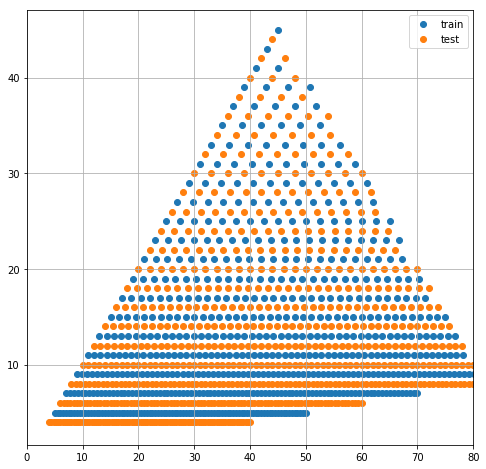

In [3]:
print('总波形数目：', data.index.shape)
train_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
test_masses = [(float(masses.split('|')[0]), float(masses.split('|')[1])) for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
print('训练集波形数目：', len(train_masses))
print('测试集波形数目：', len(test_masses))

train_m1, train_m2 = [ m[0] for m in train_masses],  [ m[1] for m in train_masses]
test_m1, test_m2 = [ m[0] for m in test_masses],  [ m[1] for m in test_masses]
plt.figure(figsize= (8,8))
plt.scatter(train_m2, train_m1, label='train')
plt.scatter(test_m2, test_m1, label = 'test')
plt.grid()
plt.legend()
plt.xlim(0,80)
# plt.title('训练集和测试集的波形在质量上的分布')
plt.show()

# 做好训练集和测试集的分割~

test_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 == 0]
train_masses = [masses for masses in data.index if float(masses.split('|')[0]) % 2 != 0]
train_data = data.loc[train_masses]
test_data = data.loc[test_masses]

## Random the peak

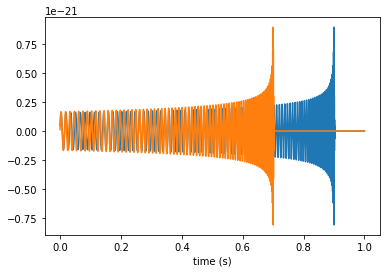

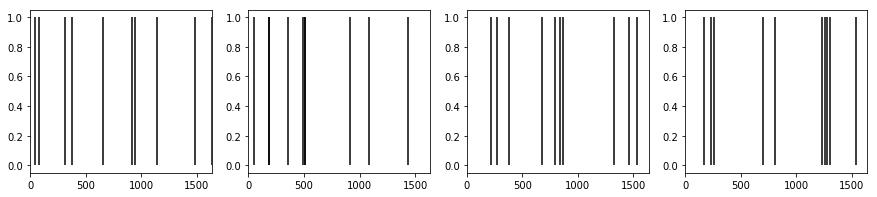

In [4]:
# def forward_moving_wave(data, a):
#     return np.concatenate((data.values[:,a:], np.array([data.values[0,-1]]*data.shape[0]*a).reshape(-1,a)), axis = 1)

# def shuffle_data(data, times):
#     shift_list = np.random.uniform(0, peak_samppoint - round((peak_time-0.2)*data.shape[-1]), size = (times))
#     base = forward_moving_wave(data, int(shift_list[0]))
    
#     index = []    
#     index.extend(data.index.tolist())
#     for shift_size in shift_list[1:]:
#         temp = forward_moving_wave(data, int(shift_size))
#         base = np.concatenate((base, temp) , axis = 0)    
#         index.extend(data.index.tolist())
#     return pd.DataFrame(base, index=index), np.array([ [s]*train_data.shape[0] for s in shift_list]).reshape(-1,)

plt.plot(np.linspace(0,1,num=data.shape[-1]),train_data.values[0,:])
plt.plot(np.linspace(0,1,num=data.shape[-1]),forward_moving_wave_nd(nd.array(train_data,ctx=ctx), peak_samppoint - round((peak_time-0.2)*data.shape[-1])).asnumpy()[0,:])
plt.xlabel('time (s)')
plt.show()
# 瞅一眼0.7~0.9的波形挪动的差别
plt.figure(figsize=(15,3))
for i in range(1, 5):
    plt.subplot(1,4,i)
    plt.vlines(np.random.uniform(0, 7371 - 5734, size = (10)), 0,1)
    plt.xlim(0,7371 - 5734)

In [26]:
tt_np = train_data.sample(100).values
tt_nd = nd.array(train_data.sample(100), ctx=mx.cpu())
peak_samppoint, peak_time = cal_peak_nd(nd.array(train_data))

In [7]:
%%time
_ = shuffle_data_np(tt_np, peak_samppoint, peak_time, 10)

CPU times: user 92 ms, sys: 68 ms, total: 160 ms
Wall time: 156 ms


In [30]:
%%time
_ = shuffle_data_nd(tt_nd,peak_samppoint, peak_time, 10)

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 9.37 ms


In [35]:
%timeit _ = shuffle_data_np(tt_np,peak_samppoint, peak_time, 10)
%timeit _ = shuffle_data_nd(tt_nd,peak_samppoint, peak_time, 10)

154 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
55.1 ms ± 925 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%lprun -f shuffle_data_nd shuffle_data_nd(tt_nd, peak_samppoint, peak_time, 100)

Timer unit: 1e-06 s

Total time: 0.017721 s
File: /floyd/home/data_utils.py
Function: shuffle_data_nd at line 265

Line #      Hits         Time  Per Hit   % Time  Line Contents
   265                                           def shuffle_data_nd(data, peak_samppoint, peak_time, times):
   266         1        348.0    348.0      2.0      shift_list = nd.random_uniform(0, peak_samppoint - round((peak_time-0.2)*data.shape[-1]), shape=(10), ctx=mx.cpu())
   267         1       1845.0   1845.0     10.4      base = forward_moving_wave_nd(data, int(shift_list.asnumpy()[0]))
   268                                               
   269        10        433.0     43.3      2.4      for shift_size in shift_list[1:]:
   270         9       9640.0   1071.1     54.4          temp = forward_moving_wave_nd(data, int(shift_size.asnumpy()[0]))
   271         9       5351.0    594.6     30.2          base = nd.concatenate([base, temp] , axis = 0)
   272         1        104.0    104.0      0.6      ret

## Training

In [4]:
train_data.head()
train =  nd.array(train_data)#[:100,:]
test = nd.array(test_data)#[:100,:]
train.as_in_context.shape
enumerate


(600, 8192)

In [14]:
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64),
                                       'stride': ((1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max',),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), ),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), ),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), ),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), )},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0, 
#                         input_dim = (2,1,8192)
                        input_dim = (1,1,8192)
                       )
Solver = Solver_nd(model = OURS_modified, 
                   train = train,
                   test = test,
                   SNR = 1, #   params = params_tl,
                   num_epoch=10, 
                   batch_size = 256
                   ,  lr_rate=0.0003
                  ,save_checkpoints_address = './checkpoints/test/'
                  ,checkpoint_name = 'test')

# Solver = Solver_nd(model = OURS_modified, 
#                    train = GW_train,
#                    test = GW_test,
#                    SNR = 1, 
#                    num_epoch=30, 
#                    batch_size = 256
#                    ,  lr_rate=0.0003)

self.train_ori.shape != self.test_ori.shape
Label for training: (12000,)
Label for testing: (12980,)


In [15]:
Solver.Training()

Epoch 1, Moving_loss: 0.692971, Epoch_loss(mean): 0.693160, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 2, Moving_loss: 0.693042, Epoch_loss(mean): 0.693156, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 3, Moving_loss: 0.693084, Epoch_loss(mean): 0.693153, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 4, Moving_loss: 0.693109, Epoch_loss(mean): 0.693152, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 5, Moving_loss: 0.693125, Epoch_loss(mean): 0.693152, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 6, Moving_loss: 0.693135, Epoch_loss(mean): 0.693151, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 7, Moving_loss: 0.693140, Epoch_loss(mean): 0.693149, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Working on epoch 8. Curr_loss: 0.69310 (complete percent: 40.53/100)
Early stoping at epoch=8
Finished!


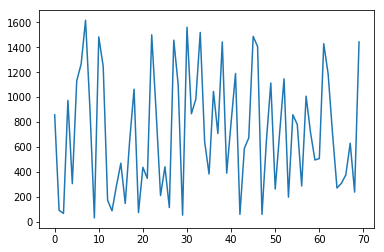

In [163]:
plt.plot(Solver.train_shift_list)

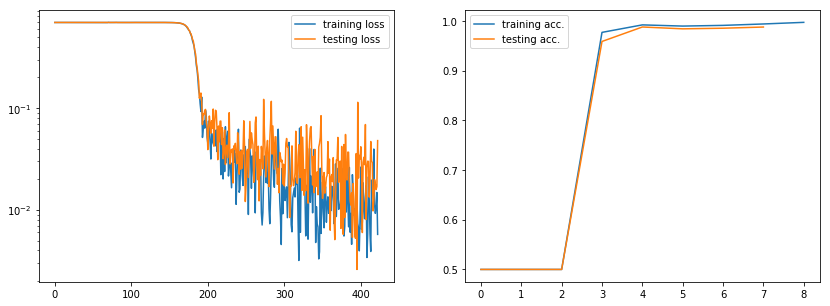

In [48]:
# finite noises
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.semilogy(Solver.loss_history, label = 'training loss')
plt.plot(Solver.loss_v_history, label = 'testing loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(Solver.train_acc_history, label = 'training acc.')
plt.plot(Solver.test_acc_history, label = 'testing acc.')
plt.legend()
plt.show()

In [50]:
params_tl = Solver.best_params

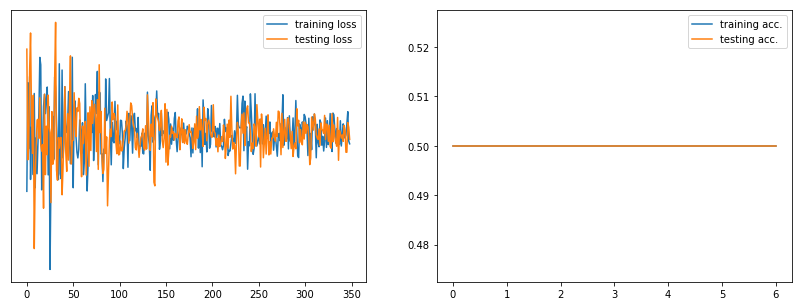

In [16]:
# finite noises
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.semilogy(Solver.loss_history, label = 'training loss')
plt.plot(Solver.loss_v_history, label = 'testing loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(Solver.train_acc_history, label = 'training acc.')
plt.plot(Solver.test_acc_history, label = 'testing acc.')
plt.legend()
plt.show()

In [13]:
Solver.params

In [11]:
nd.save('%s_info.pkl' %(Solver.checkpoint_name), checkpoint)
nd.save('%s_params_epoch@%s.pkl' %(Solver.checkpoint_name, Solver.epoch), Solver.params)
checkpoint

ValueError: data needs to either be a NDArray, dict of str, NDArray pairs or a list of NDarrays.

In [167]:
# params_tl
!ls -alh checkpoints/test/

total 56M
drwxr-xr-x 2 root root 4.0K Oct 14 07:19 .
drwxr-xr-x 3 root root 4.0K Oct 14 07:18 ..
-rw-r--r-- 1 root root 7.9M Oct 14 07:19 test_best_params_epoch@5.pkl
-rw-r--r-- 1 root root 7.9M Oct 14 07:19 test_info.pkl
-rw-r--r-- 1 root root 7.9M Oct 14 07:18 test_params_epoch@1.pkl
-rw-r--r-- 1 root root 7.9M Oct 14 07:19 test_params_epoch@2.pkl
-rw-r--r-- 1 root root 7.9M Oct 14 07:19 test_params_epoch@3.pkl
-rw-r--r-- 1 root root 7.9M Oct 14 07:19 test_params_epoch@4.pkl
-rw-r--r-- 1 root root 7.9M Oct 14 07:19 test_params_epoch@5.pkl
-rw-r--r-- 1 root root  920 Oct 14 07:18 test_structure_epoch.pkl.npy


In [18]:
nd.load('./checkpoints/test/test_best_params_epoch@7.pkl').keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5', 'W6', 'b6', 'W7', 'b7'])

In [19]:
nd.load('./checkpoints/test/test_info.pkl').keys()

dict_keys(['lr_decay', 'lr_rate', 'batch_size', 'train_shift_list', 'test_shift_list', 'num_epoch', 'epoch', 'loss_history', 'loss_v_history', 'moving_loss_history', 'train_acc_history', 'test_acc_history'])

In [20]:
nd.load('./checkpoints/test/test_params_epoch@3.pkl').keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4', 'W5', 'b5', 'W6', 'b6', 'W7', 'b7'])

In [21]:
np.load('./checkpoints/test/test_structure_epoch.pkl.npy').tolist()

{'params_inits': None,
 'conv_params': {'kernel': ((1, 16), (1, 8), (1, 8), (1, 8)),
  'num_filter': (8, 16, 32, 64),
  'stride': ((1, 1), (1, 1), (1, 1), (1, 1)),
  'padding': ((0, 0), (0, 0), (0, 0), (0, 0)),
  'dilate': ((1, 1), (1, 1), (1, 1), (1, 1))},
 'act_params': {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
 'pool_params': {'pool_type': ('max', 'max', 'max', 'max'),
  'kernel': ((1, 8), (1, 8), (1, 8), (1, 8)),
  'stride': ((1, 2), (1, 2), (1, 2), (1, 2)),
  'padding': ((0, 0), (0, 0), (0, 0), (0, 0)),
  'dilate': ((1, 1), (1, 1), (1, 1), (1, 1))},
 'fc_params': {'hidden_dim': (64, 64)},
 'drop_prob': 0,
 'input_dim': (1, 1, 8192)}

# Two Channels

In [68]:
import sys, os
sys.path.append(os.path.abspath(''))   # 把当前目录设为引用模块的地址之一

from utils import *
from data_utils import *
from models.solver_cnn import *
from models.ConvNet import *

import numpy as np
import pandas as pd
from itertools import product, permutations

import matplotlib.pyplot as plt
from sklearn import metrics

# for auto-re00loading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Easily Profile Python Code in Jupyter
# install conda install line_profiler or pip install line-profiler
# see http://mortada.net/easily-profile-python-code-in-jupyter.html
%load_ext line_profiler

test_ctx()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
CPU or GPU? :  gpu(0)


## Load Data

In [2]:
!ls ../input/gw_data

GW_H1.npy  GW_H1_index.npy  GW_L1.npy  GW_L1_index.npy


In [3]:
if ctx == mx.cpu():
    num = 1000
    GW_address = './data/'
elif ctx == mx.gpu():
    GW_address = '../input/gw_data/'

GW_data_H1 = pd.DataFrame(np.load(GW_address + 'GW_H1.npy', ), index=np.load(GW_address + 'GW_H1_index.npy'))
GW_data_L1 = pd.DataFrame(np.load(GW_address + 'GW_L1.npy', ), index=np.load(GW_address + 'GW_L1_index.npy'))
print(GW_data_H1.shape)
print(GW_data_L1.shape)

if ctx == mx.cpu():
    GW_data_H1 = GW_data_H1.head(num)

# noise_sample = nd.load('noise')[0]
# noise_sample.shape
# noise_sample = noise_sample[:num,:]

(1330, 8192)
(1330, 8192)


- glimpse

In [4]:
print(GW_data_H1.shape)
GW_data_H1.head()

(1330, 8192)


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
5.00|5.00,1.054130e-22,9.922528e-23,9.279175e-23,8.612821e-23,7.925107e-23,7.217726e-23,6.492422e-23,5.750983e-23,4.995236e-23,4.227047e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5.13|4.87,1.160190e-22,1.103344e-22,1.043764e-22,9.815966e-23,9.169958e-23,8.501203e-23,7.811349e-23,7.102095e-23,6.375191e-23,5.632430e-23,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5.26|4.74,1.449005e-22,1.412315e-22,1.372125e-22,1.328535e-22,1.281651e-22,1.231590e-22,1.178474e-22,1.122434e-22,1.063608e-22,1.002142e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5.41|4.59,1.598507e-22,1.603821e-22,1.605156e-22,1.602509e-22,1.595885e-22,1.585300e-22,1.570778e-22,1.552355e-22,1.530076e-22,1.503994e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
5.56|4.44,9.587190e-23,1.021275e-22,1.081296e-22,1.138630e-22,1.193135e-22,1.244674e-22,1.293118e-22,1.338345e-22,1.380242e-22,1.418704e-22,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [5]:
print(GW_data_L1.shape)
GW_data_L1.head()

(1330, 8192)


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
5.00|5.00,-1.484704e-22,-1.469948e-22,-1.451561e-22,-1.429585e-22,-1.404075e-22,-1.375093e-22,-1.342710e-22,-1.307005e-22,-1.268066e-22,-1.225987e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.13|4.87,-1.499905e-22,-1.491955e-22,-1.480317e-22,-1.465019e-22,-1.446100e-22,-1.423603e-22,-1.397584e-22,-1.368107e-22,-1.335244e-22,-1.299075e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.26|4.74,-1.466213e-22,-1.481578e-22,-1.493279e-22,-1.501287e-22,-1.505580e-22,-1.506148e-22,-1.502988e-22,-1.496107e-22,-1.485521e-22,-1.471256e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.41|4.59,-1.076203e-22,-1.126906e-22,-1.174820e-22,-1.219825e-22,-1.261808e-22,-1.300665e-22,-1.336299e-22,-1.368620e-22,-1.397547e-22,-1.423008e-22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.56|4.44,4.710359e-24,-2.731377e-24,-1.016725e-23,-1.757875e-23,-2.494738e-23,-3.225479e-23,-3.948275e-23,-4.661323e-23,-5.362842e-23,-6.051083e-23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- divided into training/testing dataset

In [6]:
TTmass = pd.Series(GW_data_H1.index.unique().tolist()).map(lambda x: int(float(x.split('|')[0]) + float(x.split('|')[1]))).unique()
TTmass.sort()
mass_step = TTmass[1] - TTmass[0]

# 总质量的 index
train_index = [m for m in GW_data_H1.index.unique().tolist() if float(m.split('|')[0]) + float(m.split('|')[1]) in range(TTmass[0], TTmass[-1]+mass_step, 2*mass_step)]
test_index = [m for m in GW_data_H1.index.unique().tolist() if float(m.split('|')[0]) + float(m.split('|')[1]) in range(TTmass[0]+mass_step, TTmass[-1]+mass_step, 2*mass_step)]

if ctx == mx.gpu():
    assert len(train_index) == len(test_index)
    
print('Number of unique masses for training/testing: %s/%s' %(len(train_index), len(test_index)) )

Number of unique masses for training/testing: 665/665


- multi-channel (2 channels)

In [7]:
# From Panyi + Liu
GW_data_train_reshape = []
for index in train_index:
    temp_H1 = GW_data_H1[GW_data_H1.index == index].values
    temp_L1 = GW_data_L1[GW_data_L1.index == index].values
    temp = np.concatenate((temp_H1.reshape((1,1,8192)), temp_L1.reshape((1,1,8192))),axis=1)
    GW_data_train_reshape.extend(temp)
    
GW_data_test_reshape = []
for index in test_index:
    temp_H1 = GW_data_H1[GW_data_H1.index == index].values
    temp_L1 = GW_data_L1[GW_data_L1.index == index].values
    temp = np.concatenate((temp_H1.reshape((1,1,8192)), temp_L1.reshape((1,1,8192))),axis=1)
    GW_data_test_reshape.extend(temp)    
    
print(np.array(GW_data_train_reshape).shape)
print(np.array(GW_data_test_reshape).shape)

(665, 2, 8192)
(665, 2, 8192)


In [8]:
# %%time
# from itertools import product
# GW_data_train_reshape = []
# for index in train_index:
#     temp = GW_data[GW_data.index == index].values
    
#     for value in product(range(10),range(10)):
#         GW_data_train_reshape.extend(temp[value,:].reshape((-1,len(value),8192)))

# GW_data_test_reshape = []
# for index in test_index:
#     temp = GW_data[GW_data.index == index].values
    
#     for value in product(range(10),range(10)):
#         GW_data_test_reshape.extend(temp[value,:].reshape((-1,len(value),8192)))

In [9]:
GW_train = nd.array(GW_data_train_reshape, ctx=ctx)
print(GW_train.shape)
GW_test = nd.array(GW_data_test_reshape, ctx=ctx)
print(GW_test.shape)

(665, 2, 8192)
(665, 2, 8192)


In [10]:
del GW_data_H1, GW_data_L1, GW_data_test_reshape, GW_data_train_reshape

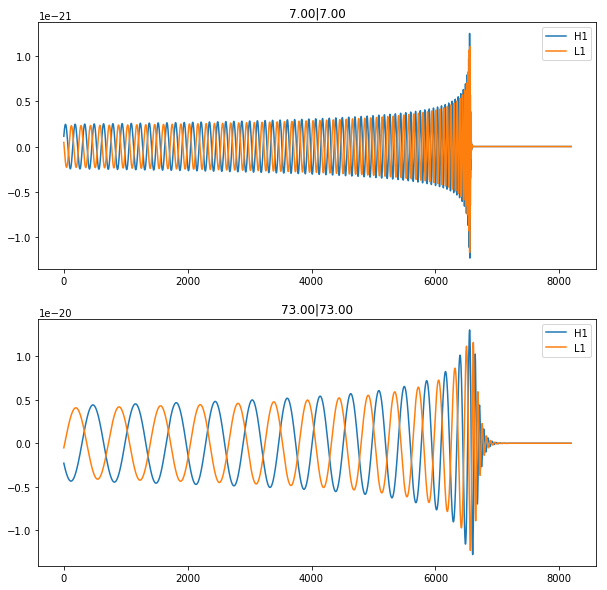

In [11]:
a = 12
plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.plot(GW_train.asnumpy()[a,0,:], label = 'H1')
plt.plot(GW_train.asnumpy()[a,1,:], label = 'L1')
plt.legend()
plt.title(train_index[a])
a = 500
plt.subplot(2,1,2)
plt.plot(GW_train.asnumpy()[a,0,:], label = 'H1')
plt.plot(GW_train.asnumpy()[a,1,:], label = 'L1')
plt.legend()
plt.title(train_index[a])
plt.show()

In [12]:
GW_train.reshape((GW_train.shape[0],1,-1)).shape

(665, 1, 16384)

## Check the efficiency of the generator of colored noises

- 不混合

In [135]:
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64),
                                       'stride': ((1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max',),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), ),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), ),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), ),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), )},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0, 
#                         input_dim = (2,1,8192)
                        input_dim = (1,1,2*8192)
                       )
Solver = Solver_nd(model = OURS_modified, 
                   train = GW_train.reshape((GW_train.shape[0],1,-1)), 
                   test = GW_test.reshape((GW_test.shape[0],1,-1)), 
                   SNR = 1, 
                   num_epoch=30, 
                   batch_size = 256
                   ,  lr_rate=0.0003)

# Solver = Solver_nd(model = OURS_modified, 
#                    train = GW_train,
#                    test = GW_test,
#                    SNR = 1, 
#                    num_epoch=30, 
#                    batch_size = 256
#                    ,  lr_rate=0.0003)

Label for training: (1330,)
Label for testing: (1330,)


In [136]:
Solver.Training()

Epoch 1, Moving_loss: 0.693111, Epoch_loss(mean): 0.693163, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 2, Moving_loss: 0.693114, Epoch_loss(mean): 0.693156, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 3, Moving_loss: 0.693117, Epoch_loss(mean): 0.693173, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 4, Moving_loss: 0.693119, Epoch_loss(mean): 0.693139, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 5, Moving_loss: 0.693119, Epoch_loss(mean): 0.693122, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 6, Moving_loss: 0.693096, Epoch_loss(mean): 0.692737, Train_acc 0.5000, Test_acc 0.5000(Best:0.5000)
Epoch 7, Moving_loss: 0.692854, Epoch_loss(mean): 0.689001, Train_acc 1.0000, Test_acc 1.0000(Best:1.0000)
Epoch 8, Moving_loss: 0.691516, Epoch_loss(mean): 0.670140, Train_acc 1.0000, Test_acc 1.0000(Best:1.0000)
Epoch 9, Moving_loss: 0.686641, Epoch_loss(mean): 0.608676, Train_acc 1.0000, Test_acc 1.0000(Best:1.0000)
Epoch 10, Moving_loss: 0.674213, Epoc

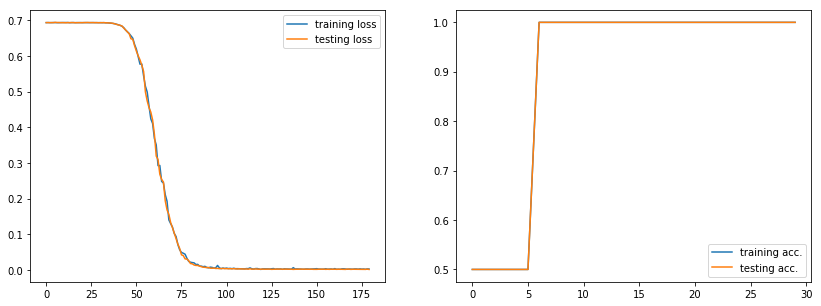

In [137]:
# finite noises
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(Solver.loss_history, label = 'training loss')
plt.plot(Solver.loss_v_history, label = 'testing loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(Solver.train_acc_history, label = 'training acc.')
plt.plot(Solver.test_acc_history, label = 'testing acc.')
plt.legend()
plt.show()

nd.save('./pretrained_models/non_mixed_fn_SNR=1', Solver.best_params)

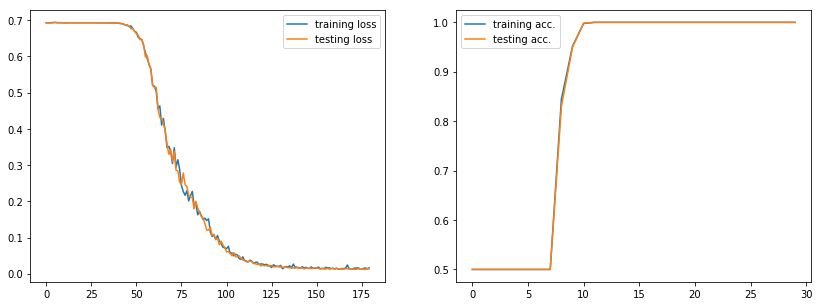

In [134]:
# infinite noises
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(Solver.loss_history, label = 'training loss')
plt.plot(Solver.loss_v_history, label = 'testing loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(Solver.train_acc_history, label = 'training acc.')
plt.plot(Solver.test_acc_history, label = 'testing acc.')
plt.legend()
plt.show()

nd.save('./pretrained_models/non_mixed_in_SNR=1', Solver.best_params)

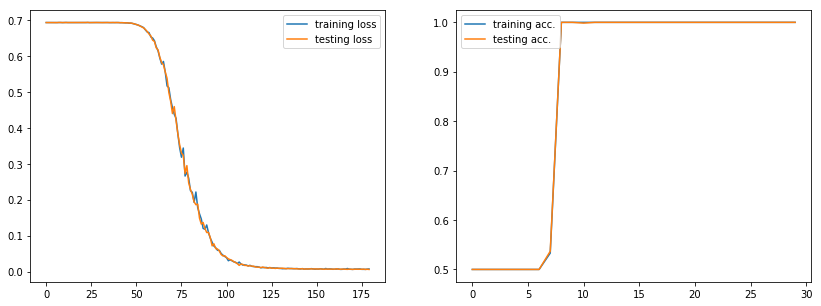

In [81]:
# infinite noises
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(Solver.loss_history, label = 'training loss')
plt.plot(Solver.loss_v_history, label = 'testing loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(Solver.train_acc_history, label = 'training acc.')
plt.plot(Solver.test_acc_history, label = 'testing acc.')
plt.legend()
plt.show()

nd.save('./pretrained_models/infinite_noise_SNR=1', Solver.best_params)

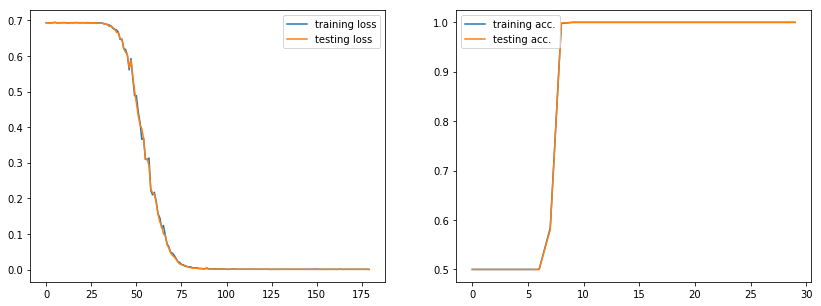

In [88]:
# finite noises
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(Solver.loss_history, label = 'training loss')
plt.plot(Solver.loss_v_history, label = 'testing loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(Solver.train_acc_history, label = 'training acc.')
plt.plot(Solver.test_acc_history, label = 'testing acc.')
plt.legend()
plt.show()

nd.save('./pretrained_models/finite_noise_SNR=1', Solver.best_params)



## Predict

In [106]:
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64),
                                       'stride': ((1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max',),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), ),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), ),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), ),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), )},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0, 
                        params_inits = nd.load('./pretrained_models/finite_noise_SNR=1'),
                        input_dim = (2,1,8192)
#                         input_dim = (1,1,2*8192)
                       )
auc_list = []
for snr in np.linspace(0.1, 1, 10):
    Solver = Solver_nd(model = OURS_modified, 
                       train = GW_train,#.reshape((GW_train.shape[0],1,-1)), 
                       test = GW_test,#.reshape((GW_test.shape[0],1,-1)), 
                       SNR = snr, 
                       batch_size = 256)
    auc_var_list = []
    for i in range(10):
        prob, label, _= Solver.predict_nd()
        fpr, tpr, thresholds = metrics.roc_curve(label, prob, pos_label=1)
        auc_var_list.append(metrics.auc(fpr, tpr))
        if i == 9: break
            
    auc_list.append(auc_var_list)

np.save('./images/auc_finite_noise_SNR=1', auc_list)

Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)


In [108]:
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64),
                                       'stride': ((1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max',),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), ),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), ),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), ),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), )},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0, 
                        params_inits = nd.load('./pretrained_models/infinite_noise_SNR=1'),
                        input_dim = (2,1,8192)
#                         input_dim = (1,1,2*8192)
                       )
auc_list = []
for snr in np.linspace(0.1, 1, 10):
    Solver = Solver_nd(model = OURS_modified, 
                       train = GW_train,#.reshape((GW_train.shape[0],1,-1)), 
                       test = GW_test,#.reshape((GW_test.shape[0],1,-1)), 
                       SNR = snr, 
                       batch_size = 256)
    auc_var_list = []
    for i in range(10):
        prob, label, _= Solver.predict_nd()
        fpr, tpr, thresholds = metrics.roc_curve(label, prob, pos_label=1)
        auc_var_list.append(metrics.auc(fpr, tpr))
        if i == 9: break
            
    auc_list.append(auc_var_list)
np.save('./images/auc_infinite_noise_SNR=1', auc_list)

Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)


In [110]:
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64),
                                       'stride': ((1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max',),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), ),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), ),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), ),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), )},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0, 
                        params_inits = nd.load('./pretrained_models/non_mixed_fn_SNR=1'),
#                         input_dim = (2,1,8192)
                        input_dim = (1,1,2*8192)
                       )
auc_list = []
for snr in np.linspace(0.1, 1, 10):
    Solver = Solver_nd(model = OURS_modified, 
                       train = GW_train.reshape((GW_train.shape[0],1,-1)), 
                       test = GW_test.reshape((GW_test.shape[0],1,-1)), 
                       SNR = snr, 
                       batch_size = 256)
    auc_var_list = []
    for i in range(10):
        prob, label, _= Solver.predict_nd()
        fpr, tpr, thresholds = metrics.roc_curve(label, prob, pos_label=1)
        auc_var_list.append(metrics.auc(fpr, tpr))
        if i == 9: break
            
    auc_list.append(auc_var_list)
np.save('./images/auc_non_mixed_fn_SNR=1', auc_list)

Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)


In [111]:
OURS_modified = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                                       'num_filter': (8, 16, 32, 64),
                                       'stride': ((1,1), (1,1), (1,1), (1,1)),
                                       'padding': ((0,0), (0,0), (0,0), (0,0)),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1))},
                        act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                        pool_params = {'pool_type': ('max', 'max', 'max', 'max',),
                                       'kernel': ((1,8), (1,8), (1,8), (1,8), ),
                                       'stride': ((1,2), (1,2), (1,2), (1,2), ),
                                       'padding': ((0,0),(0,0), (0,0), (0,0), ),
                                       'dilate': ((1,1), (1,1), (1,1), (1,1), )},
                        fc_params = {'hidden_dim': (64,64)}, drop_prob = 0, 
                        params_inits = nd.load('./pretrained_models/non_mixed_in_SNR=1'),
#                         input_dim = (2,1,8192)
                        input_dim = (1,1,2*8192)
                       )
auc_list = []
for snr in np.linspace(0.1, 1, 10):
    Solver = Solver_nd(model = OURS_modified, 
                       train = GW_train.reshape((GW_train.shape[0],1,-1)), 
                       test = GW_test.reshape((GW_test.shape[0],1,-1)), 
                       SNR = snr, 
                       batch_size = 256)
    auc_var_list = []
    for i in range(10):
        prob, label, _= Solver.predict_nd()
        fpr, tpr, thresholds = metrics.roc_curve(label, prob, pos_label=1)
        auc_var_list.append(metrics.auc(fpr, tpr))
        if i == 9: break
            
    auc_list.append(auc_var_list)
np.save('./images/auc_non_mixed_in_SNR=1', auc_list)

Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)
Label for training: (1330,)
Label for testing: (1330,)


## Plot AUC

In [112]:
address = './images/'
auc_non_mixed_in = np.load(address + 'auc_non_mixed_in_SNR=1.npy')
auc_non_mixed_fn = np.load(address + 'auc_non_mixed_fn_SNR=1.npy')
auc_infinite_noise = np.load(address + 'auc_infinite_noise_SNR=1.npy')
auc_finite_noise = np.load(address + 'auc_finite_noise_SNR=1.npy')

In [116]:
auc_non_mixed_in.mean(axis=1)

array([0.95374967, 0.95379626, 0.95489129, 0.95479835, 0.95188445,
       0.95215173, 0.953196  , 0.95705048, 0.95009803, 0.95194596])

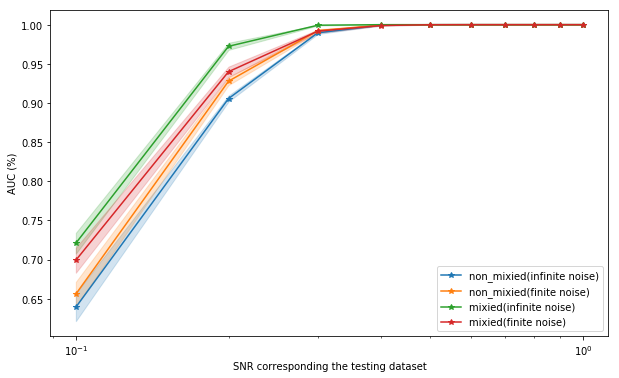

In [144]:
plt.figure(figsize=(10,6))
xrange = np.linspace(0.1, 1, 10)
plt.plot(xrange, auc_non_mixed_in.mean(axis=1), '*-', color = 'tab:blue', label = 'non_mixied(infinite noise)')
plt.plot(xrange, auc_non_mixed_fn.mean(axis=1), '*-', color = 'tab:orange', label = 'non_mixied(finite noise)')
plt.plot(xrange, auc_infinite_noise.mean(axis=1), '*-', color = 'tab:green', label = 'mixied(infinite noise)')
plt.plot(xrange, auc_finite_noise.mean(axis=1), '*-', color = 'tab:red' ,label = 'mixied(finite noise)')
plt.xlabel('SNR corresponding the testing dataset')
plt.ylabel('AUC (%)')
plt.legend()
plt.fill_between(xrange, y1 = auc_non_mixed_in.mean(axis=1)-auc_non_mixed_in.std(axis=1)
                 ,y2 = auc_non_mixed_in.mean(axis=1)+auc_non_mixed_in.std(axis=1) ,color='tab:blue', alpha=.2,
                 label='std. dev.')
plt.fill_between(xrange, y1 = auc_non_mixed_fn.mean(axis=1)-auc_non_mixed_fn.std(axis=1)
                 ,y2 = auc_non_mixed_fn.mean(axis=1)+auc_non_mixed_fn.std(axis=1) ,color='tab:orange', alpha=.2,
                 label='std. dev.')
plt.fill_between(xrange, y1 = auc_infinite_noise.mean(axis=1)-auc_infinite_noise.std(axis=1)
                 ,y2 = auc_infinite_noise.mean(axis=1)+auc_infinite_noise.std(axis=1) ,color='tab:green', alpha=.2,
                 label='std. dev.')
plt.fill_between(xrange, y1 = auc_finite_noise.mean(axis=1)-auc_finite_noise.std(axis=1)
                 ,y2 = auc_finite_noise.mean(axis=1)+auc_finite_noise.std(axis=1) ,color='tab:red', alpha=.2,
                 label='std. dev.')
plt.xscale('log')
plt.show()

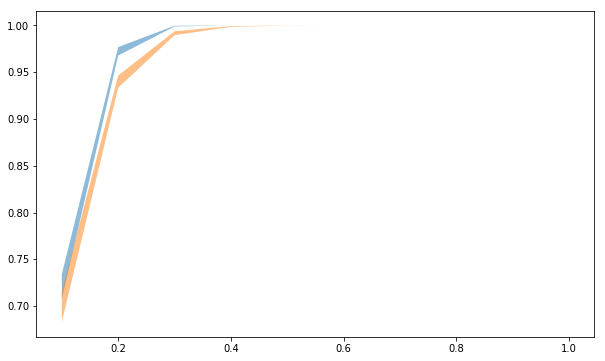

In [141]:
plt.figure(figsize=(10,6))
# plt.fill_between(xrange, y1 = auc_non_mixed_in.mean(axis=1)-auc_non_mixed_in.std(axis=1)
#                  ,y2 = auc_non_mixed_in.mean(axis=1)+auc_non_mixed_in.std(axis=1) , alpha=.2,
#                  label='std. dev.')
# plt.legend()
# plt.fill_between(xrange, y1 = auc_non_mixed_fn.mean(axis=1)-auc_non_mixed_fn.std(axis=1)
#                  ,y2 = auc_non_mixed_fn.mean(axis=1)+auc_non_mixed_fn.std(axis=1), alpha=.2,
#                  label='std. dev.')
plt.fill_between(xrange, y1 = auc_infinite_noise.mean(axis=1)-auc_infinite_noise.std(axis=1)
                 ,y2 = auc_infinite_noise.mean(axis=1)+auc_infinite_noise.std(axis=1) , alpha=.5,
                 label='std. dev.')
plt.fill_between(xrange, y1 = auc_finite_noise.mean(axis=1)-auc_finite_noise.std(axis=1)
                 ,y2 = auc_finite_noise.mean(axis=1)+auc_finite_noise.std(axis=1) , alpha=.5,
                 label='std. dev.')
plt.show()


In [ ]:
# noise for mixing
noise = Solver.gen_noise()

sigma = self.train.max(axis = 2) / float(self.SNR) / nd.array(noise[:self.train_size].asnumpy().std(axis = 2,dtype='float64'),ctx=ctx)
self.sigma = sigma
signal_train = nd.divide(self.train, sigma.reshape((self.train_size,self.num_channel,-1)))
data_train = signal_train + noise[:self.train_size]

sigma = self.test.max(axis = 2) / float(self.SNR) / nd.array(noise[-self.test_size:].asnumpy().std(axis = 2,dtype='float64'),ctx=ctx)
signal_test = nd.divide(self.test, sigma.reshape((self.test_size,self.num_channel,-1)))    
data_test = signal_test + noise[-self.test_size:]

# noise for pure conterpart
noise = Solver.gen_noise()

X_train = Normolise_nd(nd.concat(data_train, noise[:self.train_size], dim=0), self.num_channel)
dataset_train = gluon.data.ArrayDataset(X_train, self.y_train)
self.train_data = gluon.data.DataLoader(dataset_train, self.batch_size, shuffle=True, last_batch='keep')

X_test = Normolise_nd(nd.concat(data_test, noise[-self.test_size:], dim=0), self.num_channel)
dataset_test = gluon.data.ArrayDataset(X_test, self.y_test)
self.test_data = gluon.data.DataLoader(dataset_test, self.batch_size, shuffle=True, last_batch='keep')

In [122]:
# n = Solver.gen_noise()
n = Pre_zero(size =  (Solver.train.shape[1:]))
noise, _ = TimeseriesFromPSD_nd(n)

In [52]:
(Solver.train_size+Solver.test_size,) + (Solver.train.shape[1:])

(133000, 2, 8192)

In [53]:
(Solver.train_size+Solver.test_size,) +

(2, 8192)

In [123]:
noise


[[-5.3376343e-22  7.5018107e-22  3.3527911e-22 ...  4.8249065e-22
   1.0454106e-22 -5.3002284e-22]
 [ 8.2155746e-22 -1.0554492e-21  5.4476331e-22 ... -1.8151350e-21
   2.0940215e-21 -1.8045983e-21]]
<NDArray 2x8192 @gpu(0)>

In [ ]:
# Solver.Training()

In [13]:
def Pre_zero_(ZERO_DET = ZERO_DET, size = (1,2*8192), fs = 8192, fmin = 20, fmax = 4000):
    (D, *N) = size  # N is a list
    low_f_max = fmin
    high_f_min = fmax
    # Interpolation
    freqs = fftfreq(N[-1], 1./fs)
    asd_zero = np.interp(freqs[(freqs>=ZERO_DET[:,0].min())&(freqs<=high_f_min)], ZERO_DET[:,0], ZERO_DET[:,1]) 

    shiftsize = int(low_f_max - ZERO_DET[:,0].min())
    xf = fftfreq(N[-1], 1./fs)
    xf_noise = xf[xf>=0]
    slc, slc_, slc__ = (xf_noise >= low_f_max)&(xf_noise<=high_f_min), (xf_noise < low_f_max), (xf_noise > high_f_min)

    if ctx == mx.gpu():
        asd_zero = nd.array(asd_zero, ctx = ctx, dtype='float64')
        asd_pos = nd.square(asd_zero)[shiftsize:]
        asd_neg = nd.square(asd_zero)[shiftsize:][::-1]    
    elif ctx == mx.cpu():
        asd_pos = np.square(asd_zero)[shiftsize:]
        asd_neg = np.square(asd_zero)[shiftsize:][::-1]            
    else:
        raise

    assert slc_.argmin() == slc.argmax()
    low_f = slc_.argmin()
    high_f = slc[slc.argmax():].argmin()+slc.argmax()
    high_f_ = N[-1]//2 - slc__.argmax()
    
    return asd_pos, asd_neg, low_f, high_f, high_f_, size, fs, fmin, fmax

In [25]:
ZERO_DET = np.loadtxt('ZERO_DET_high_P.txt')
# size = (1,2*8192)
# fs = 8192
# fmin = 20
# fmax = 4000

# (D, *N) = size  # N is a list
# low_f_max = fmin
# high_f_min = fmax
# # Interpolation
# freqs = fftfreq(N[-1], 1./fs)
# asd_zero = np.interp(freqs[(freqs>=ZERO_DET[:,0].min())&(freqs<=high_f_min)], ZERO_DET[:,0], ZERO_DET[:,1]) 

# print(asd_zero.shape)

# shiftsize = int(low_f_max - ZERO_DET[:,0].min())
# xf = fftfreq(N[-1], 1./fs)
# xf_noise = xf[xf>=0]  # 8192
# slc, slc_, slc__ = (xf_noise >= low_f_max)&(xf_noise<=high_f_min), (xf_noise < low_f_max), (xf_noise > high_f_min)

# if ctx == mx.gpu():
#     asd_zero = nd.array(asd_zero, ctx = ctx, dtype='float64')
#     asd_pos = nd.square(asd_zero)[shiftsize * N[-1]//8192:]
#     asd_neg = nd.square(asd_zero)[shiftsize * N[-1]//8192:][::-1]    
# elif ctx == mx.cpu():
#     asd_pos = np.square(asd_zero)[shiftsize:]
#     asd_neg = np.square(asd_zero)[shiftsize:][::-1]            
# else:
#     raise
    
# assert slc_.argmin() == slc.argmax()
# low_f = slc_.argmin()
# high_f = slc[slc.argmax():].argmin()+slc.argmax()
# high_f_ = N[-1]//2 - slc__.argmax()
# print(low_f, high_f, high_f_)
# assert asd_pos.shape[0] == high_f - low_f

(7983,)
40 8001 191


In [20]:
(3992,)
20 4001 95

SyntaxError: invalid syntax (<ipython-input-20-a2183922c151>, line 2)

2

In [21]:
slc

array([False, False, False, ..., False, False, False])

In [17]:
param_noise=Pre_zero_(ZERO_DET = ZERO_DET, size = (1,2*8192), fs = 8192, fmin = 20, fmax = 4000)

In [ ]:
# n,_ = TimeseriesFromPSD_nd(param_noise)

In [87]:
# (asd_pos, asd_neg, low_f, high_f, high_f_, size, fs, fmin, fmax) = param_noise
(*D_, N) = size
D = reduce(lambda x, y: x * y, D_)
# Gauss noise and its one-sided PSD without window
gauss_noise = 1* nd.random_normal(loc=0,scale=64,shape=(D, N), ctx=ctx)
_, xf_noise, psd_gauss = oneSidedPeriodogram_nd(gauss_noise, fs=8192)
psd_gauss = nd.array(psd_gauss, ctx = ctx, dtype='float64')

# psd_twosided  = nd.concat(  # low positive
#                           nd.zeros((D, low_f), ctx = ctx, dtype='float64'), 
#                             # high positive
#                           psd_gauss[:, low_f:high_f] * asd_pos, 
#                           nd.zeros((D, high_f_), ctx = ctx, dtype='float64'),
#                           nd.zeros((D, high_f_), ctx = ctx, dtype='float64'),
#                             # high negative
#                           psd_gauss[:, low_f:high_f][::-1] * asd_neg, 
#                             # low negative
#                           nd.zeros((D, low_f), ctx = ctx, dtype='float64'), dim=1)
# amplitude =  nd.sqrt(psd_twosided *2 *fs*N )
# epsilon_imag = nd.random_uniform(low=0, high=1, shape=(D,N),ctx=ctx,dtype='float64')*2*np.pi
# re = nd.cos(epsilon_imag)*amplitude
# im = nd.sin(epsilon_imag)*amplitude
# temp = nd.zeros((D, N*2) , ctx=ctx)
# temp[:,::2] = re
# temp[:,1::2] = im
# timeseries = mx.contrib.ndarray.ifft(temp)/N
# return timeseries.reshape(size),  psd_twosided

In [86]:
low_f, high_f, high_f_, size, fs, fmin, fmax

(20, 4001, 95, (2, 8192), 8192, 20, 4000)

In [89]:
nd.zeros((D, low_f))
asd_pos


[3.66442145e-46 3.01000101e-46 2.50398757e-46 ... 3.05223448e-46
 3.05370944e-46 3.05518474e-46]
<NDArray 3981 @gpu(0)>

In [70]:
asd_neg


[3.05518474e-46 3.05444705e-46 3.05370944e-46 ... 1.09441061e-45
 1.27349645e-45 1.49544035e-45]
<NDArray 7972 @gpu(0)>

In [88]:
psd_gauss[:, low_f:high_f]# * asd_pos


[[0.62626302 0.1770955  0.36134014 ... 1.43389273 0.30036923 1.25007415]
 [0.58644944 0.0140889  0.0662284  ... 0.76718205 0.02861047 0.1479142 ]]
<NDArray 2x3981 @gpu(0)>

In [16]:
%lprun -f Solver.Training Solver.Training()
# %lprun -f Solver._reset_noise() Solver._reset_noise()
# %lprun -f Solver.gen_noise() Solver.gen_noise()

UsageError: Could not find function 'Solver.gen_noise()'.
MXNetError: [15:49:17] src/storage/./pooled_storage_manager.h:119: cudaMalloc failed: out of memory

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x37db4a) [0x7f98db99cb4a]
[bt] (1) /usr/local/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x37e161) [0x7f98db99d161]
[bt] (2) /usr/local/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x31c859b) [0x7f98de7e759b]
[bt] (3) /usr/local/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x31cd305) [0x7f98de7ec305]
[bt] (4) /usr/local/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x2a9d4c6) [0x7f98de0bc4c6]
[bt] (5) /usr/local/lib/python3.6/site-packages/mxnet/libmxnet.so(MXNDArrayCreateEx+0x158) [0x7f98de0bcd38]
[bt] (6) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7f992f752e40]
[bt] (7) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x2eb) [0x7f992f7528ab]
[bt] (8) /usr/local/lib/python3.6/lib-dynload/_ctypes.cpython

In [15]:
model = ConvNet(conv_params = {'kernel': ((1,16), (1,8), (1,8), (1,8)), 
                               'num_filter': (16//2, 32//2, 64//2, 64),
                               'stride': ((1,1), (1,1), (1,1), (1,1)),
                               'padding': ((0,0), (0,0), (0,0), (0,0)),
                               'dilate': ((1,1), (1,1), (1,1), (1,1))},
                act_params = {'act_type': ('elu', 'elu', 'elu', 'elu', 'elu', 'elu')},
                pool_params = {'pool_type': ('max', 'max', 'max', 'max'),
                               'kernel': ((1,8), (1,8), (1,8), (1,8)),
                               'stride': ((1,2), (1,2), (1,2), (1,2)),
                               'padding': ((0,0), (0,0), (0,0), (0,0)),
                               'dilate': ((1,1), (1,1), (1,1), (1,1))},
                fc_params = {'hidden_dim': (128, 64)},
                input_dim = (2, 1, 8192)
)
Solver = Solver_nd(model = model, train = GW_train, test = GW_test, SNR = 1,num_epoch=10
                   ,  lr_rate=0.003)

Loading the params...
self.train.shape != self.test.shape
Label for training: (11000,)
Label for testing: (9000,)


In [16]:
Info = Solver.Training()

for index, info in enumerate(Info):
    (loss_history, loss_v_history, moving_loss_history, train_accuracy_history, test_accuracy_history) = info


Early stoping at epoch=1
Finished!


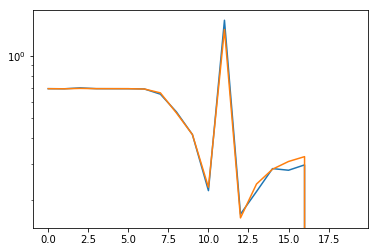

In [30]:
plt.semilogy(loss_history)
plt.semilogy(loss_v_history)
# plt.plot(moving_loss_history)

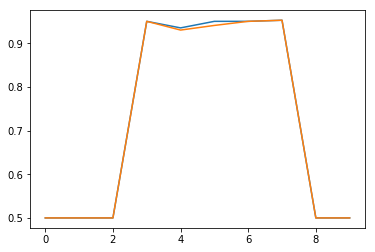

In [29]:
plt.plot(test_accuracy_history)
plt.plot(train_accuracy_history)

In [83]:
noise, _ = TimeseriesFromPSD_nd(Solver.param_noise)

In [96]:
# nd.array(noise[:Solver.train_size,:].asnumpy().std(axis = 1),ctx=ctx)
tt = noise[:Solver.train_size,:]
tt.asnumpy().std(axis = 1,dtype='float64')

array([  9.37602972e-22,   9.42728322e-22,   9.46455932e-22, ...,
         9.43608796e-22,   9.53370731e-22,   9.50264772e-22])

In [ ]:
noise.

In [99]:
Solver.lr_rate

Solver.sigma


[ 0.05984845  0.05823757  0.05879105 ...,  0.27456239  0.27948043
  0.27278998]
<NDArray 6650 @gpu(0)>

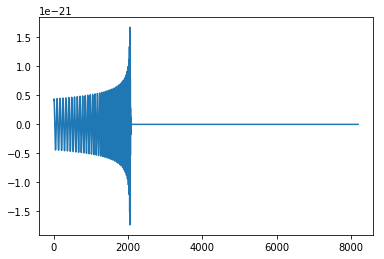

In [81]:
plt.plot(Solver.train.asnumpy()[2,:])


[-0.00012025  0.0088126 ]
<NDArray 2 @gpu(0)>


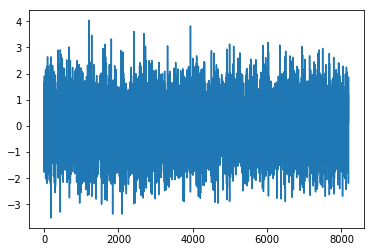

In [44]:
# model.params
num = 8
for batch_i, (data, label) in enumerate(Solver.train_data):
    _, output = Solver.loss(data, label, train=False)
    plt.plot(data[num,:].asnumpy())
    print(output[num,:])
    break

In [148]:
# for param, v, sqr in zip(model.params, tt.vs, tt.sqrs):
#     print(model.params[param])
#     print(v)
#     print()

In [210]:
dd = {'33': 43}

In [211]:
nd.save('check', dd)

TypeError: save only accept dict str->NDArray or list of NDArray

In [6]:
SNR = 1
GW_train = nd.array(GW_data.drop(test_index), ctx=ctx)
GW_test = nd.array(GW_data.drop(train_index), ctx=ctx)


In [7]:
train_size = GW_train.shape[0]
test_size = GW_test.shape[0]
noiseAll_size = train_size+test_size

noise_sample.shape

(1000, 8192)

In [8]:
SNR = 1
GW_train = nd.array(GW_data.drop(test_index), ctx=ctx)
GW_test = nd.array(GW_data.drop(train_index), ctx=ctx)

sigma = GW_train.max(axis = 1) / float(SNR) / nd.array(noise_sample[:train_size,:].asnumpy().std(axis = 1))
signal = nd.divide(GW_train, sigma.reshape((-1,1)))
data = signal + noise_sample[:train_size,:]
data_train = nd.concat(data, noise_sample[:train_size,:], dim=0)

sigma = GW_test.max(axis = 1) / float(SNR) / nd.array(noise_sample[:test_size].asnumpy().std(axis = 1))
signal = nd.divide(GW_test, sigma.reshape((-1,1)))
data = signal + noise_sample[:test_size]
data_test = nd.concat(data, noise_sample[:test_size], dim=0)

print(data_train.shape)
print(data_test.shape)

(1100, 8192)
(900, 8192)


In [12]:
from mxnet.gluon.data.vision.transforms import Normalize as Normalize_nd

In [13]:
y = nd.concat(nd.ones(shape = (train_size,), ctx = ctx), nd.zeros(shape = (train_size,), ctx = ctx) , dim = 0)

In [30]:
tt = Normalize_nd(mean = 0, std = 1 )

In [33]:
data_train[6].reshape((1,1,8192))


[[[ -1.44131294e-21   1.31616633e-21  -1.94223689e-22 ...,  -2.08484881e-22
    -8.99958067e-22   8.52112858e-22]]]
<NDArray 1x1x8192 @cpu(0)>

In [34]:
tt(data_train[6].reshape((1,1,8192)))


[[[ -1.44131294e-21   1.31616633e-21  -1.94223689e-22 ...,  -2.08484881e-22
    -8.99958067e-22   8.52112858e-22]]]
<NDArray 1x1x8192 @cpu(0)>

In [54]:
y = nd.concat(nd.ones(shape = (train_size,), ctx = ctx), nd.zeros(shape = (train_size,), ctx = ctx) , dim = 0)
X = Normolise_nd(data_train)

In [56]:
batch_size = 20
dataset_train = gluon.data.ArrayDataset(X, y)
train_data = gluon.data.DataLoader(dataset_train, batch_size, shuffle=True, last_batch='keep')

In [57]:
train_data

In [51]:
data_norm.shape

(1100, 8192)

In [ ]:
pool_type='max'
pool_size = 8
pool_stride= 2
# 64256 16
# 64832 6
# 64704 8
# 64960 4
# 65024 2
sl = 32352

In [ ]:
SNR = 1
# params_ = nd.load('./New_params/params_8')
# params_ = nd.load('./SNR1.dms')
print('Start Training at SNR = %s ...' %str(SNR))
Info = Solver(train = train_dict['1']
          ,test = test_dict['1'], Debug=True , params_init = None#params_
             , batch_size=256, lr=0.000000001, epochs=2
             , smoothing_constant = .01, SNR = SNR
             , sl=sl, pool_type=pool_type ,pool_size = pool_size,pool_stride=pool_stride
             , num_fc1 = 64, num_fc2 = 64, num_outputs = 2, period = 256)

# test_accuracy_history_final = [0]
for index, info in enumerate(Info):
    (params, loss_history, loss_v_history, moving_loss_history, test_accuracy_history, train_accuracy_history) = info
    # Save
#     for key, value in {'params':params
# #                                  , 'loss_history': nd.array(loss_history)
# #                                  , 'loss_v_history': nd.array(loss_v_history)
# #                                  , 'moving_loss_history': nd.array(moving_loss_history)
# #                                  , 'test_accuracy_history': nd.array(test_accuracy_history)
# #                                  , 'train_accuracy_history': nd.array(train_accuracy_history)
#                       }.items():

#         nd.save("./%s/%s_%s" %(address,key,index+1), value)

In [1]:
import numpy as np
np.log(2)

0.69314718055994529

In [2]:
np.log(10)

2.3025850929940459

In [1]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
print("hello world from process ", rank)

hello world from process  0


In [2]:
comm

In [82]:
def SQUARE_MATRIX_MULTIPLY(A, B):
    n = A.shape[0]
    C = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            C[i,j] = 0
            for k in range(n):
                C[i,j] += A[i,k] * B[k,j]
    return C

A = np.array([[1,2,3], [2,3,4], [5,6,7]])
B = np.array([[9,8,7], [8,7,6], [7,6,5]])

In [102]:
def SQUARE_MATRIX_MULTIPLY_RECURSIVE(A, B):
    n = A.shape[0]
    C = np.empty((n,n))
    if n == 1:
        C[0,0] = A[0,0] * B[0,0] # 其实可以不用写 [0,0]
    else:
        C[:n//2, :n//2] = SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[:n//2, :n//2], B[:n//2, :n//2]) + SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[:n//2, n//2:], B[n//2:, :n//2])
        C[:n//2, n//2:] = SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[:n//2, :n//2], B[:n//2, n//2:]) + SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[:n//2, n//2:], B[n//2:, n//2:])
        C[n//2:, :n//2] = SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[n//2:, :n//2], B[:n//2, :n//2]) + SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[n//2:, n//2:], B[n//2:, :n//2])
        C[n//2:, n//2:] = SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[n//2:, :n//2], B[:n//2, n//2:]) + SQUARE_MATRIX_MULTIPLY_RECURSIVE(A[n//2:, n//2:], B[n//2:, n//2:])
    return C

In [86]:
%timeit SQUARE_MATRIX_MULTIPLY(A, B)

43.2 µs ± 7.14 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [87]:
%timeit A.dot(B)

1.39 µs ± 92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [105]:
A = np.array([[1,2,3,4], [2,3,4,5], [5,6,7,8], [6,7,8,9]])
B = np.array([[9,8,7,6], [8,7,6,5], [7,6,5,4], [6,5,4,3]])

In [108]:
%timeit SQUARE_MATRIX_MULTIPLY(A, B)

68.6 µs ± 6.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [106]:
%timeit SQUARE_MATRIX_MULTIPLY_RECURSIVE(A, B)

295 µs ± 35.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [107]:
%timeit A.dot(B)

1.57 µs ± 62.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


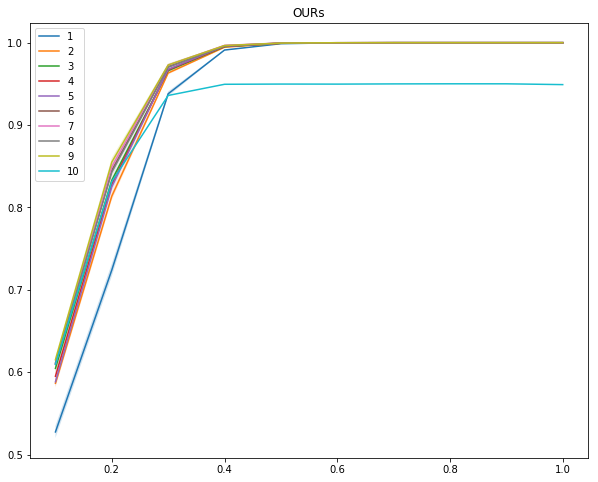

In [76]:
AUC_OURs = np.load('/Users/Herb/Downloads/AUC_OURs.npy')
AUC_OURs_ = np.load('/Users/Herb/Downloads/AUC_OURs_.npy')
xrange = np.linspace(0.1,1,10)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.plot(xrange,AUC_OURs[i].mean(axis=1), label=i+1)
#     plt.plot(AUC_PRL[i].mean(axis=1),'*-', label=i)
    plt.fill_between(xrange, y1 = AUC_OURs[i].mean(axis=1)-AUC_OURs[i].std(axis=1)
                     ,y2 = AUC_OURs[i].mean(axis=1)+AUC_OURs[i].std(axis=1) ,alpha=.2)    
plt.plot(xrange,AUC_OURs_[0].mean(axis=1), label=10)
plt.title('OURs')    
plt.legend()

In [105]:
conv_params = {'kernel': ((1,16), (1,8), (1,8)),
            'num_filter': (16, 32, 64,),
            'stride': ((1,1), (1,1), (1,1),),
            'padding': ((0,0), (0,0), (0,0),),
            'dilate': ((1,1), (1,1), (1,1),)}
act_params = {'act_type': ('relu', 'relu', 'relu', 'relu',)}
pool_params = {'pool_type': ('avg', 'avg', 'avg',),
            'kernel': ((1,16), (1,16), (1,16),),
            'stride': ((1,2), (1,2), (1,2),),
            'padding': ((0,0),(0,0), (0,0),),
            'dilate': ((1,1), (1,1), (1,1),)}

In [171]:
num_layers = 3
conv_params = {'kernel':((1,16),) + ((1,8),)*(num_layers-1),
                                        'num_filter': temp(1+(num_layers-1)),
                                        'stride': ((1,1),) + ((1,1),)*(num_layers-1),
                                        'padding':((0,0),) + ((0,0),)*(num_layers-1),
                                        'dilate': ((1,1),) + ((1,1),)*(num_layers-1)}
act_params = {'act_type': (('relu',))*2 +  (('relu',))*(num_layers-1)}
pool_params = {'pool_type':(('avg'),) + (('avg'),)*(num_layers-1),
            'kernel': ((1,16),) + ((1,16),)*(num_layers-1),
            'stride': ((1,2),) + ((1,2),)*(num_layers-1),
            'padding':((0,0),) + ((0,0),)*(num_layers-1),
            'dilate': ((1,1),) + ((1,1),)*(num_layers-1)}
drop_prob = 0

In [251]:
drop_prob_list = [0] *1 +[0.25,0.5,0.75]

hidden_dim_list = [16]*1 + [16*2**i for i in range(4+1) if 16*2**i != 64]
fc_params_list = [{'hidden_dim': (64,)}]*1+ [{'hidden_dim': (64,)*(i+2)} for i in range(3)]
act_params_list = [{'act_type': ('relu',)*4}]*1+ [{'act_type': ('relu',)*(i+5)} for i in range(3)]
act_type_list = ['relu']*1 + ['elu']*3

dialute_list = [1]*1 + [2, 3]
num_filter_list = [(16,32,64)]*1+ [(4*2**(i), 8*2**(i), 16*2**(i)) for i in range(1+3) if 4*2**(i) != 16]

In [184]:
def Fine_tune(name, value):
    default = {'default':{'drop_prob': 0,
                          'fc_params_act_type': ({'hidden_dim':(64,)},
                                                 {'act_type': ('relu',)*4}),
                          'pool_type_kernel': (('avg','avg','avg',), 
                                               ((1,16), (1,16), (1,16),)),
                          'dialute': 1,
                          'num_filter': (16,32,64) }}
    df = pd.DataFrame(default)
    df.drop([name], inplace=True)
    params_list = []
    for i,j in product(value, dict(df).values()):
        dd = dict(j)
        dd[name] = i
        dd['hidden_dim'] = dd['fc_params_act_type'][0]
        dd['act_type'] = dd.pop('fc_params_act_type')[1]
        dd['pool_type'] = dd['pool_type_kernel'][0]
        dd['pool_kernel'] = dd.pop('pool_type_kernel')[1]        
        params_list.append(dd)
    return params_list
def test(diedai):
    for hyperparam in diedai:
        hidden_dim = hyperparam['hidden_dim']
        drop_prob = hyperparam['drop_prob']
        num_filter = hyperparam['num_filter']
        act_type= hyperparam['act_type']
        dialute= hyperparam['dialute']
        pool_kernel = hyperparam['pool_kernel']
        pool_type = hyperparam['pool_type']
        print()
        print('hidden_dim |', hidden_dim)
        print('drop_prob |' , drop_prob)
        print('num_filter |', num_filter)
        print('act_type |' , act_type)
        print('dialute |', dialute)
        print('pool_kernel |', pool_kernel)
        print('pool_type |', pool_type)

In [319]:
# fc_params_act_type = ([{'hidden_dim': (64,)*(i+2)} for i in range(3)], [{'act_type': ('relu',)*(i+5)} for i in range(3)])
# fc_params_act_type = [i for i in zip(fc_params_act_type[0], fc_params_act_type[1])]
# test(Fine_tune('fc_params_act_type', fc_params_act_type))

In [320]:
# test(Fine_tune('drop_prob', [0.75,0.5,0.25]));
# test(Fine_tune('dialute', [3,2]));
# test(Fine_tune('num_filter', [(4*2**(i), 8*2**(i), 16*2**(i)) for i in range(1+3)[::-1] if 4*2**(i) != 16]));

In [321]:
# test(Fine_tune('fc_params_act_type', [({'hidden_dim': (64,)}, {'act_type': ('elu',)*4})]))
# print()
# values = ([{'hidden_dim': (16*2**i,)} for i in range(4+1)[::-1] if 16*2**i != 64], [{'act_type': ('relu',)*4}])
# values = [i for i in product(values[0], values[1])]
# test(Fine_tune('fc_params_act_type', values))

In [322]:
# from itertools import product, permutations
# values = [4*2**i for i in range(4)[::-1]] + [4*2**i for i in range(4)[::-1] if 4*2**i != 16]
# values = [((1,i), (1,i), (1,i)) for i in values]
# pool_type_tuple = ('max',)*4+('avg',)*3
# test(Fine_tune('pool_type_kernel', [i for i in zip(pool_type_tuple, values)]))

In [288]:
check_dict_dim(conv_params)

In [266]:
def temp(x):
    if x == 1: return (16,)
    else: return temp(x-1) + (16*2**(x-1),)

conv_params, act_params, pool_params

NameError: name 'conv_params' is not defined

In [160]:
conv_params = {'kernel': ((1,16), (1,8), (1,8)), 
            'num_filter': num_filter,
            'stride': ((1,1), (1,1), (1,1),),
            'padding': ((0,0), (0,0), (0,0),),
            'dilate': ((1,1), (1,1), (1,1),)}
act_params = {'act_type': ('relu', 'relu', 'relu', 'relu',)}
pool_params = {'pool_type': ('avg', 'avg', 'avg',),
            'kernel': ((1,16), (1,16), (1,16),),
            'stride': ((1,2), (1,2), (1,2),),
            'padding': ((0,0),(0,0), (0,0),),
            'dilate': ((1,1), (1,1), (1,1),)},
fc_params = {'hidden_dim': (64,)}, drop_prob = 0

(16, 32, 64)

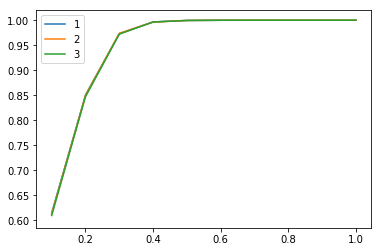

In [260]:
def plot_AUC(AUC):
#     plt.figure(figsize=(8,5))
    xrange = np.linspace(0.1,1,10)
    for i in range(AUC.shape[0]):
        plt.plot(xrange, AUC[i].mean(axis=1),label =i+1)
        plt.fill_between(xrange, y1 = AUC[i].mean(axis=1)-AUC[i].std(axis=1)
                     ,y2 = AUC[i].mean(axis=1)+AUC[i].std(axis=1) ,alpha=.2)
    plt.legend()
plot_AUC(np.load('/Users/Herb/Downloads/AUC_OURs-3.npy'))

In [317]:
!ls data_AUC/

AUC_OURs.npy               AUC_dropout02_75_05_25.npy
AUC_PRL.npy                AUC_elu02.npy
AUC_dialute02_3_2.npy      AUC_numfilter02_32_8_4.npy


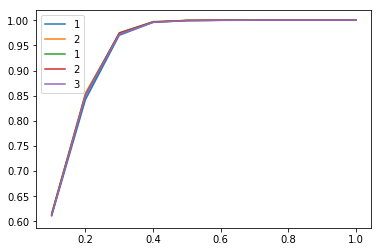

In [315]:

# plot_AUC(np.load('/Users/Herb/Downloads/AUC_OURs.npy')[:-1])
AUC_OURs = np.load('/Users/Herb/Downloads/AUC_OURs.npy')[-3:-1]
plot_AUC(AUC_OURs)
# AUC_OURs_ = np.load('/Users/Herb/Downloads/AUC_OURs_.npy')
# plot_AUC(AUC_OURs_)
plot_AUC(np.load('/Users/Herb/Downloads/AUC_OURs-5.npy'))
# plot_AUC(np.concatenate((AUC_OURs, AUC_OURs_),axis=0))
# np.save('./data_AUC/AUC_OURs', np.concatenate((AUC_OURs, AUC_OURs_),axis=0))

In [316]:
np.save( './data_AUC/AUC_numfilter02_32_8_4', np.load('/Users/Herb/Downloads/AUC_OURs-5.npy'))

In [65]:
print(AUC_OURs.mean(axis=2)[-2])

[ 0.61507959  0.85501695  0.97290068  0.99651916  0.9995603   0.99996144
  0.99999721  0.99999984  1.          1.        ]


In [74]:
for i in range(1,11):
    print(AUC_PLB.mean(axis=2)[-2])
    break

[ 0.71127458  0.9672442   0.99796582  0.99969344  0.99995068  0.99999636
  0.9999991   0.9999999   1.          1.        ]


In [70]:
for i in range(1,11):
    print(AUC_PRL.mean(axis=2)[-6])
    break

[ 0.52132462  0.58674147  0.68400786  0.7980826   0.89398269  0.95507699
  0.98297783  0.99399076  0.99817959  0.99943288]


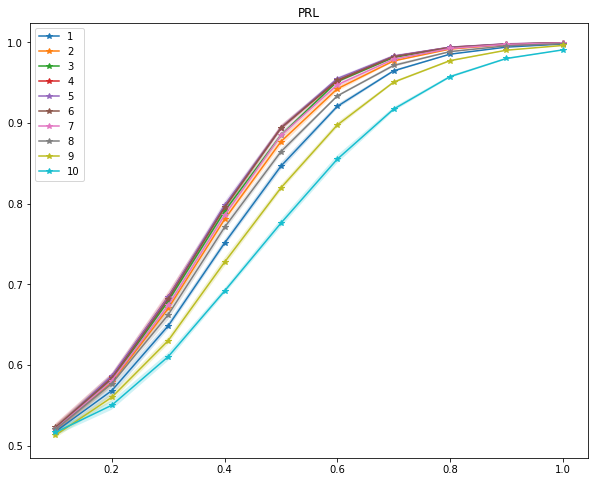

In [89]:
AUC_PRL = np.load('./data_AUC/AUC_PRL.npy')
plt.figure(figsize=(10,8))
xrange = np.linspace(0.1,1,10)
for i in range(10):
    plt.plot(xrange, AUC_PRL[i].mean(axis=1),'*-', label=i+1)
    plt.fill_between(xrange, y1 = AUC_PRL[i].mean(axis=1)-AUC_PRL[i].std(axis=1)
                     ,y2 = AUC_PRL[i].mean(axis=1)+AUC_PRL[i].std(axis=1) ,alpha=.2)
plt.title('PRL')
plt.legend()

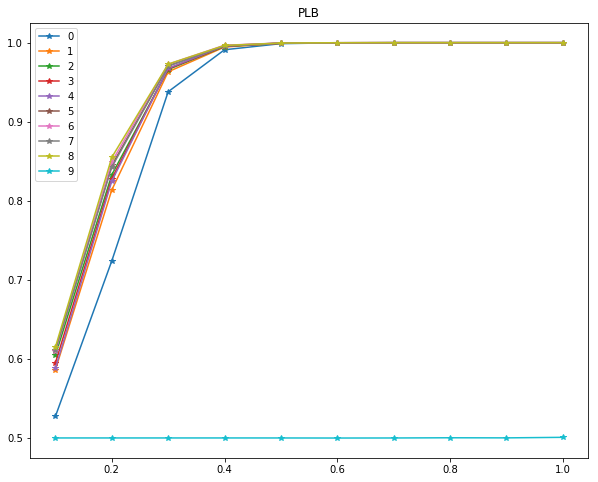

In [52]:
# !ls /Users/Herb/Downloads/AUC*
AUC_PLB = np.load('/Users/Herb/Downloads/AUC_PLB.npy')
plt.figure(figsize=(10,8))
xrange = np.linspace(0.1,1,10)
for i in range(10):
    plt.plot(xrange, AUC_OURs[i].mean(axis=1),'*-', label=i)
#     plt.plot(xrange, AUC_PLB[i].mean(axis=1),'g*-', label=i)
#     plt.plot(xrange, AUC_PRL[i].mean(axis=1),'y*-', label=i)

plt.title('PLB')
plt.legend()